In [26]:
import numpy as np
from scipy.special import gamma, erf, hyp2f1, jn, betaln
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation

# Параметры (пример)
c_tr, c_cap, c_ope = 0.08, 25, 10
e_tr, e_proc = 0.12, 0.20
p_gas = 0.045
w = 0.5
e_ene = 3.0
p_fert = 30
alpha_l = 0.3
C_max = 25000
R_max = 60000

d = np.array([10, 20, 15, 30, 25])
S = np.array([6000, 8000, 5000, 7000, 4000])
s = np.array([0.8, 0.6, 0.9, 0.5, 0.7])
R_i = np.ones(5)

# Границы для нормализации — более реалистичные
TC_min, TC_max   =  5e5, 2.5e6     # € — от простых до полностью автоматизированных установок
GHG_min, GHG_max =  2e3, 1.2e4     # kg CO₂-eq — от эффективных до неэффективных сценариев
WF_min, WF_max   =  5e3, 2e4       # m³ — учитывает воду на гигиену и переработку
EC_min, EC_max   =  2e4, 1.2e5     # kWh — на микс насосов, перемешивания, контроля
ER_min, ER_max   =  1e4, 6e4       # € — зависит от цен на газ и выхода
NV_min, NV_max   =  2e3, 2.5e4     # € — рыночная ценность удобрений
SI_min, SI_max   =  0.5, 5.0       # индекс — условная шкала санитарного эффекта
RE_min, RE_max   =  0.2, 1.0       # коэффициент — минимум загрузки по фермам



class BiogasMOOProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=6, n_obj=8, n_constr=3,
                         xl=np.array([0, 0, 0, 0, 0, 0]),
                         xu=np.array([S[0], S[1], S[2], S[3], S[4], 1]))

    

    def _evaluate(self, x, out, *args, **kwargs):
        x_i = x[:5]
        y = round(x[5])
    
        total_input = np.sum(x_i)
        load = total_input / C_max if C_max > 0 else 0
    
        energy_potentials = np.array([1.0, 0.8, 1.2, 0.5, 1.1])
        weighted_energy = np.sum(x_i * energy_potentials)
        mixture_entropy = -np.sum((x_i / total_input + 1e-6) * np.log(x_i / total_input + 1e-6))
        load_penalty = np.exp(-((load - 0.85) ** 2) / 0.08)
    
        base_TC = np.sum(x_i * (c_tr * d + c_ope)) * y + c_cap * total_input**0.9 * y
        gamma_scale = gamma(1 + total_input / (C_max * 10))
        TC = base_TC * (1 + 0.05 * (gamma_scale - 1)) + 1e4 * np.sin(total_input / 15000)
    
        bessel_component = jn(1, weighted_energy / 2000) + 1.5
        base_ER = p_gas * 0.4 * np.tanh((weighted_energy * (1 + 0.1 * mixture_entropy)) / 3000) * 1000 * load_penalty * bessel_component
    
        # Усложняем взаимосвязь: TC зависит не только от base_TC и ER_effect, но и от произведения с ER
        ER_effect = 1 / (1 + np.exp(-0.0001 * (base_ER - 20000)))
    
        # Вводим нелинейную связь через степень и синусоидальный шум
        TC = TC * (1 - 0.25 * ER_effect) + 1e-5 * (base_ER**1.5) * np.sin(total_input / 8000)
    
        TC_effect = np.tanh(0.000001 * (TC - 1e5))
    
        # ER тоже зависит от TC нелинейно, с кросс-термом
        ER = base_ER * (0.7 + 0.3 * TC_effect) + 5e-6 * (TC**1.3) * np.cos(total_input / 7000)
    
        erf_component = erf(total_input / (C_max / 2))
        GHG = np.sum(x_i * (e_tr * (d**1.2) + e_proc)) * y * (1 - 0.3 * erf_component) - 500 * np.log1p(np.std(x_i)) * y
    
        WF = w * total_input
    
        hypergeom_factor = hyp2f1(1, 0.5, 1.5, -total_input / (C_max * 2))
        EC = e_ene * total_input * hypergeom_factor
    
        a_param = 2 + total_input / (C_max * 5)
        b_param = 5 - total_input / (C_max * 10)
        beta_factor = np.exp(betaln(a_param, b_param) - betaln(1, 1))
    
        NV = p_fert * (alpha_l * total_input - 0.00001 * (alpha_l * total_input)**2)
    
        SI = (np.sum(s * x_i) / (1 + 0.0001 * total_input)) * beta_factor
    
        util_ratios = x_i / (S + 1e-5)
        RE = np.min(util_ratios) - 0.01 * np.var(util_ratios)
    
        TC_n  = (TC  - TC_min)  / (TC_max - TC_min)
        GHG_n = (GHG - GHG_min) / (GHG_max - GHG_min)
        WF_n  = (WF  - WF_min)  / (WF_max - WF_min)
        EC_n  = (EC  - EC_min)  / (EC_max - EC_min)
        ER_n  = (ER_max - ER)   / (ER_max - ER_min)
        NV_n  = (NV_max - NV)   / (NV_max - NV_min)
        SI_n  = (SI_max - SI)   / (SI_max - SI_min)
        RE_n  = (RE_max - RE)   / (RE_max - RE_min)
    
        out["F"] = [TC_n, GHG_n, WF_n, EC_n, ER_n, NV_n, SI_n, RE_n]
    
        g1 = total_input - C_max * y
        g2 = np.sum(R_i * x_i) - R_max
        g3 = y - 1
        out["G"] = [g1, g2, g3]



problem = BiogasMOOProblem()

algorithm = NSGA2(
    pop_size=50,
    sampling=FloatRandomSampling(),
    crossover=SimulatedBinaryCrossover(prob=0.9, eta=15),
    mutation=PolynomialMutation(eta=20),
    eliminate_duplicates=True
)

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               verbose=True)

print("Pareto optimal solutions:")
for i, X in enumerate(res.X):
    print(f"Solution {i+1}: x = {X[:5]}, y = {round(X[5])}, objectives = {res.F[i]}")


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |     23 |  0.000000E+00 |  7.619666E+03 |             - |             -
     2 |      100 |     50 |  0.000000E+00 |  0.000000E+00 |  0.2624461877 |         ideal
     3 |      150 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0408892927 |         ideal
     4 |      200 |     50 |  0.000000E+00 |  0.000000E+00 |  0.2285104728 |         ideal
     5 |      250 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0333404667 |         ideal
     6 |      300 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0286629101 |         ideal
     7 |      350 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0504413904 |         ideal
     8 |      400 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0487862175 |             f
     9 |      450 |     50 |  0.000000E+00 |  0.000000E+00 |  0.1040528657 |         ideal
    10 |      500 |     50 |  0.000000E+00 |  0.000000E+00 |  0.0106221996 |         ideal

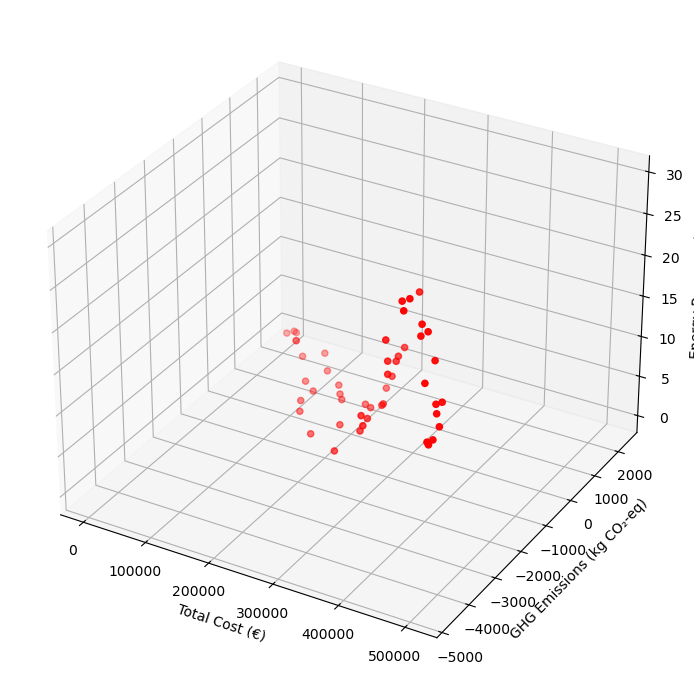

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Define real-world bounds
TC_min, TC_max   =  5e5, 2.5e6     # € — от простых до полностью автоматизированных установок
GHG_min, GHG_max =  2e3, 1.2e3     # kg CO₂-eq — от эффективных до неэффективных сценариев
WF_min, WF_max   =  5e3, 2e4       # m³ — учитывает воду на гигиену и переработку
EC_min, EC_max   =  2e4, 1.2e5     # kWh — на микс насосов, перемешивания, контроля
ER_min, ER_max   =  1e4, 6e4       # € — зависит от цен на газ и выхода
NV_min, NV_max   =  2e3, 2.5e4     # € — рыночная ценность удобрений
SI_min, SI_max   =  0.5, 5.0       # индекс — условная шкала санитарного эффекта
RE_min, RE_max   =  0.2, 1.0       # коэффициент — минимум загрузки по фермам


# Extract normalized objectives
TC_norm = F[:, 0]
GHG_norm = F[:, 1]
ER_norm = F[:, 4]

# Denormalize values
TC_real = TC_norm * (TC_max - TC_min) + TC_min
GHG_real = GHG_norm * (GHG_max - GHG_min) + GHG_min
ER_real = ER_max - ER_norm * (ER_max - ER_min)  # Inversion due to maximization

# Plotting in real units
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(TC_real, GHG_real, ER_real, c='red', marker='o')

ax.set_xlabel('Total Cost (€)')
ax.set_ylabel('GHG Emissions (kg CO₂-eq)')
ax.set_zlabel('Energy Revenue (€)')
#ax.set_title('3D Pareto Front (Real Units)')

plt.tight_layout()
plt.savefig('PF3D_real.pdf')
plt.show()


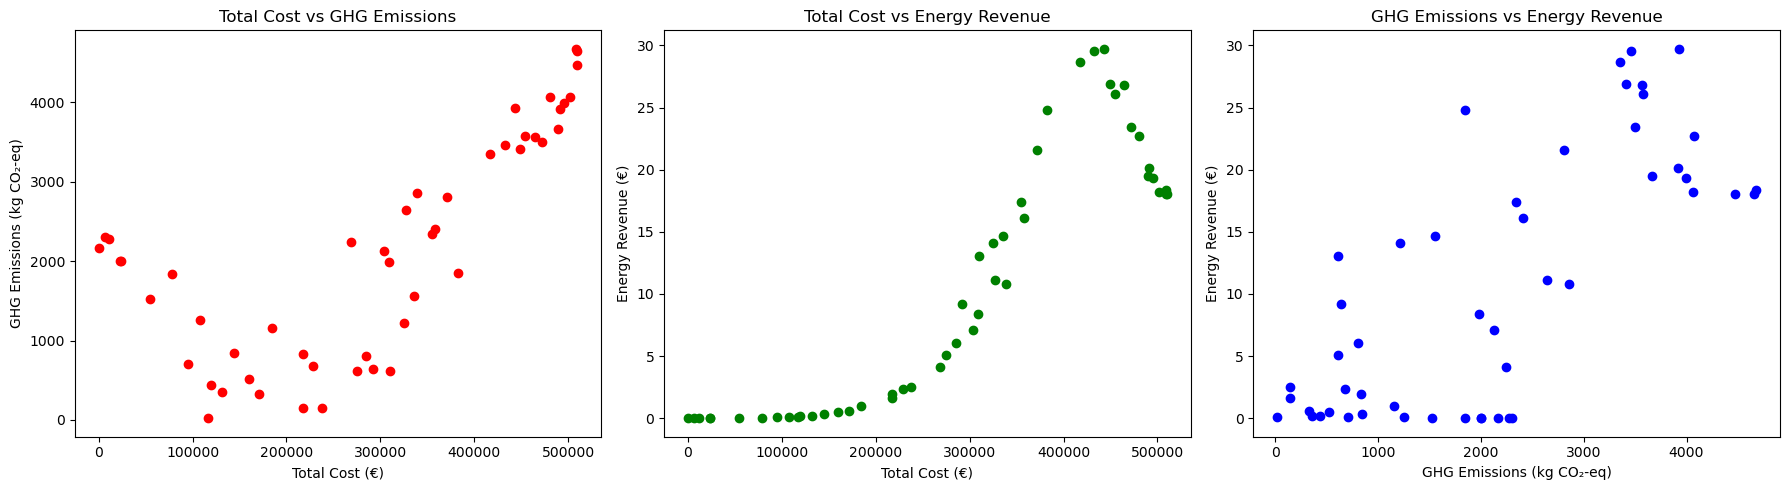

In [32]:
import matplotlib.pyplot as plt

# Define real-world bounds
TC_min, TC_max   =  5e5, 2.5e6     # € — от простых до полностью автоматизированных установок
GHG_min, GHG_max =  2e3, 1.2e3     # kg CO₂-eq — от эффективных до неэффективных сценариев
WF_min, WF_max   =  5e3, 2e4       # m³ — учитывает воду на гигиену и переработку
EC_min, EC_max   =  2e4, 1.2e5     # kWh — на микс насосов, перемешивания, контроля
ER_min, ER_max   =  1e4, 6e4       # € — зависит от цен на газ и выхода
NV_min, NV_max   =  2e3, 2.5e4     # € — рыночная ценность удобрений
SI_min, SI_max   =  0.5, 5.0       # индекс — условная шкала санитарного эффекта
RE_min, RE_max   =  0.2, 1.0       # коэффициент — минимум загрузки по фермам


# Extract normalized objectives from optimization result
TC_norm = F[:, 0]
GHG_norm = F[:, 1]
ER_norm = F[:, 4]

# Denormalize
TC_real = abs(TC_norm * (TC_max - TC_min) + TC_min)
GHG_real = abs(GHG_norm * (GHG_max - GHG_min) + GHG_min)
ER_real = abs(ER_max - ER_norm * (ER_max - ER_min))

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Total Cost vs GHG Emissions
axs[0].scatter(TC_real, GHG_real, color='red')
axs[0].set_xlabel('Total Cost (€)')
axs[0].set_ylabel('GHG Emissions (kg CO₂-eq)')
axs[0].set_title('Total Cost vs GHG Emissions')

# Subplot 2: Total Cost vs Energy Revenue
axs[1].scatter(TC_real, ER_real, color='green')
axs[1].set_xlabel('Total Cost (€)')
axs[1].set_ylabel('Energy Revenue (€)')
axs[1].set_title('Total Cost vs Energy Revenue')

# Subplot 3: GHG Emissions vs Energy Revenue
axs[2].scatter(GHG_real, ER_real, color='blue')
axs[2].set_xlabel('GHG Emissions (kg CO₂-eq)')
axs[2].set_ylabel('Energy Revenue (€)')
axs[2].set_title('GHG Emissions vs Energy Revenue')

# Layout
plt.tight_layout()
plt.savefig("PF_2D_subplots.pdf")
plt.show()


In [35]:
GHG_real

array([4651.7500865 ,  679.50716735, 4065.96259706, 2302.33142664,
       4676.48466124, 3929.8762705 ,  610.48196033, 4471.09015187,
       2164.65854276, 1526.70272352, 1998.30849625, 1844.40795138,
       1157.76416674,  829.68053015,  840.82874818, 1255.01645182,
        636.25167   , 4073.86693139,  521.26771017,  436.59005139,
        354.17919846, 1558.84722566, 2813.26839381, 2853.39824208,
       2646.20385637, 1985.09116459,  610.443426  ,  329.17678552,
       2342.33157513, 2127.20469951,  800.97737644, 2241.57006853,
       2276.45626913,  147.43947016, 1217.45005994, 3500.25665846,
       3921.9925118 , 1850.67557813, 3579.27483153, 2408.37416706,
        709.98939854, 3568.35571866, 1998.74345928, 3660.22027755,
         20.85914919,  148.65066286, 3994.51889991, 3350.30636164,
       3459.4648887 , 3411.97195032])

In [33]:
ER_real

array([1.80430673e+01, 2.37308074e+00, 1.81830485e+01, 2.82315210e-04,
       1.84012613e+01, 2.97313025e+01, 1.30518817e+01, 1.80460149e+01,
       3.56274541e-07, 1.41938428e-02, 2.12188374e-03, 4.88223312e-02,
       9.94007653e-01, 1.93917545e+00, 3.34987396e-01, 1.28920119e-01,
       9.16781366e+00, 2.27260637e+01, 4.80488376e-01, 1.76388080e-01,
       2.02965955e-01, 1.46859550e+01, 2.16234051e+01, 1.07745621e+01,
       1.11086800e+01, 8.35995519e+00, 5.08243020e+00, 5.95461992e-01,
       1.74027710e+01, 7.12615068e+00, 6.06936735e+00, 4.16345071e+00,
       6.63620420e-04, 2.54959475e+00, 1.40728285e+01, 2.34746263e+01,
       2.01042599e+01, 2.47804351e+01, 2.61157532e+01, 1.60925931e+01,
       7.95451179e-02, 2.68051176e+01, 2.10393838e-03, 1.95352453e+01,
       1.26993290e-01, 1.61816377e+00, 1.93133400e+01, 2.86496912e+01,
       2.95645509e+01, 2.68859019e+01])

In [34]:
TC_real

array([5.09979672e+05, 2.28729390e+05, 5.02181002e+05, 6.55955208e+03,
       5.08818034e+05, 4.43266235e+05, 3.10117769e+05, 5.09097661e+05,
       2.24688173e+01, 5.45139192e+04, 2.32666591e+04, 7.83064645e+04,
       1.84179498e+05, 2.17178380e+05, 1.44359291e+05, 1.07800737e+05,
       2.91861853e+05, 4.80744322e+05, 1.59926351e+05, 1.19387324e+05,
       1.31740344e+05, 3.35888441e+05, 3.71410798e+05, 3.38738270e+05,
       3.27376789e+05, 3.09376696e+05, 2.74868761e+05, 1.70986690e+05,
       3.55070850e+05, 3.03960714e+05, 2.85016452e+05, 2.68678406e+05,
       1.13729477e+04, 2.37854168e+05, 3.25291894e+05, 4.72245079e+05,
       4.91139734e+05, 3.82218438e+05, 4.54373011e+05, 3.57918165e+05,
       9.48994514e+04, 4.64368566e+05, 2.31931280e+04, 4.89781641e+05,
       1.16837975e+05, 2.17101420e+05, 4.95219533e+05, 4.17341836e+05,
       4.32961838e+05, 4.49205082e+05])

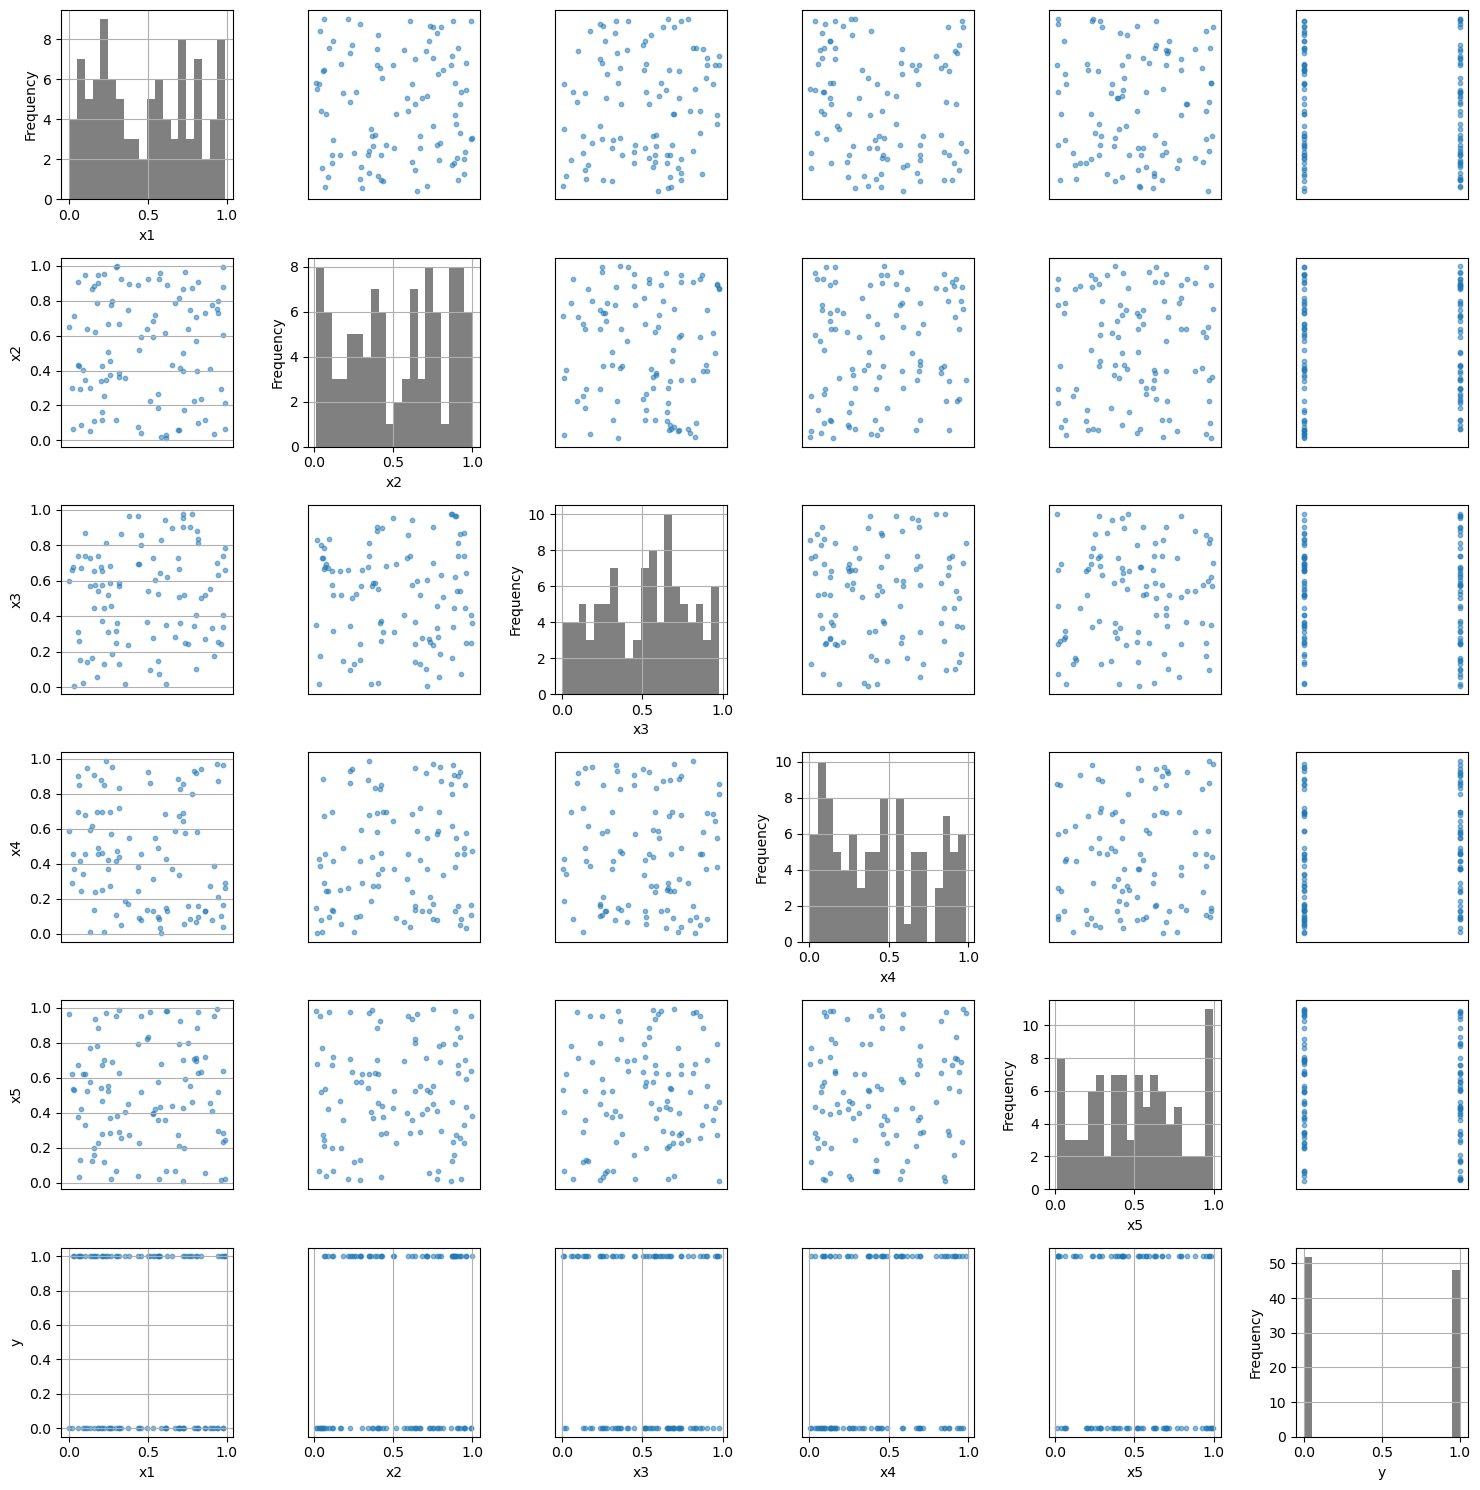

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Примерные данные: 100 решений, 6 переменных (x1,...,x5, y)
np.random.seed(0)
data = np.random.rand(100, 6)
data[:, 5] = (data[:, 5] > 0.5).astype(int)  # бинарная переменная y

var_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'y']

n_vars = data.shape[1]
fig, axes = plt.subplots(n_vars, n_vars, figsize=(15,15))

for i in range(n_vars):
    for j in range(n_vars):
        ax = axes[i, j]
        if i == j:
            # На диагонали можно показать гистограмму
            ax.hist(data[:, i], bins=20, color='gray')
            ax.set_xlabel(var_names[i])
            ax.set_ylabel('Frequency')
        else:
            ax.scatter(data[:, j], data[:, i], s=10, alpha=0.5)
            if i == n_vars - 1:
                ax.set_xlabel(var_names[j])
            else:
                ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(var_names[i])
            else:
                ax.set_yticks([])
        ax.grid(True)

plt.tight_layout()
plt.show()
